# Simple Inverse Rendering Example

## Overview

This guide demonstrates a simple example of using `irtk` to perform inverse rendering. We will use the `psdr-jit` renderer as the backend, which can be installed via
```bash
pip install psdr-jit
```

Inverse rendering is the process of recovering scene parameters from image(s). It is commonly set up in the following way:

1. Gather images (and their camera poses)of a scene.
2. Construct a scene from initial guesses of the scene parameters, which roughly resembles the scene in the images.
3. Optimize the scene parameters to minimize the difference between the rendered image and the target image by repeating the following steps:
    - Render the image from the current scene parameters.
    - Compute the loss between the rendered image and the target image.
    - Compute the gradient of the loss with respect to the scene parameters.
    - Update the scene parameters.
  
In the following, we will build such a pipeline to optimize the camera pose of a scene: we will use a single image and optimize the camera position to match the reference image.

Let's start by importing the necessary modules.

In [1]:
from irtk.scene import Scene, Mesh, DiffuseBRDF, PerspectiveCamera, HDRFilm, Integrator
from irtk.renderer import Renderer
from irtk.io import to_numpy, to_srgb, to_torch_f, write_video
from irtk.transform import lookat

import torch
import matplotlib.pyplot as plt
from pathlib import Path 

from IPython.display import Image

data_path = Path('data')

def display_image(image):
    plt.imshow(to_numpy(to_srgb(image)))
    plt.axis('off')
    plt.show()

We will construct a simple scene with a mesh and a camera. The camera is looking at the mesh.


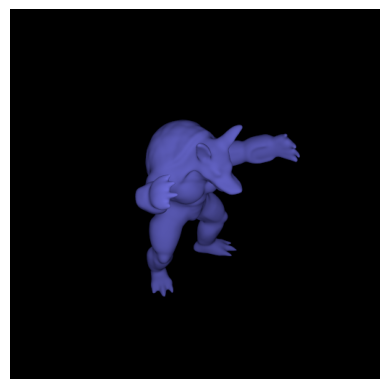

In [2]:
sensor_pos_ref = to_torch_f((-1.5, 1.5, 1.5)) # The reference camera position
target_pos = to_torch_f((0, 0, 0)) # The target position
up_dir = to_torch_f((0, 1, 0)) # The up direction

# Define reference scene
scene = Scene()
scene.set('armadillo', Mesh.from_file(data_path / 'meshes' / 'armadillo.obj', mat_id='blue'))
scene.set('blue', DiffuseBRDF((0.2, 0.2, 0.9)))
scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=sensor_pos_ref, target=target_pos, up=up_dir))
scene.set('film', HDRFilm(width=512, height=512))

# Backend-specific component
scene.set('integrator', Integrator(type='collocated', config={
        'intensity': 10
})) # A collocated integrator assumes the light source is collocated with the camera.

# Set up renderer
render = Renderer('psdr_jit', render_options={
    'spp': 128,
    'sppe': 0,
    'sppse': 0,
    'log_level': 0,
    'npass': 1
})

# Render the reference image
image_ref = render(scene)[0]

display_image(image_ref)

Next, we will set up the initial guess. We will keep the the camera's target and up direction fixed, and only optimize the camera's position.


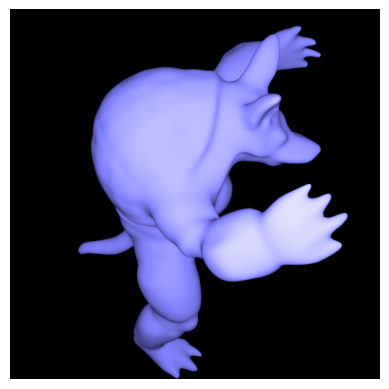

In [3]:
# Switch to initial scene
sensor_pos_init = to_torch_f((-1, 1, 0)) # The initial camera position
scene.set('sensor', PerspectiveCamera.from_lookat(fov=40, origin=sensor_pos_init, target=target_pos, up=up_dir))

# Render the initial image
image_init = render(scene)[0]

display_image(image_init)

We are ready to optimize the camera position. 


In [4]:
# Training configuration
num_iter = 100
log_iter = 10
lr = 0.03

# Set up the parameter to optimize
sensor_pos = sensor_pos_init.clone()
sensor_pos.requires_grad = True
scene['sensor.to_world'] = lookat(origin=sensor_pos, target=target_pos, up=up_dir)
scene.configure()

# Set up the optimizer
optimizer = torch.optim.Adam([sensor_pos], lr=lr)

# Record the training process
record = {
    'training_view': [],
    'image_loss': [],
    'param_error': [],
}

# Training loop
for i in range(1, num_iter + 1):

    # Clear the gradient
    optimizer.zero_grad()

    # Render the training view
    image_opt = render(scene)[0]

    # Compute the image loss
    image_loss = (image_ref - image_opt).abs().mean() # L1 loss
    image_loss.backward()

    # Update the parameters
    optimizer.step()
    scene['sensor.to_world'] = lookat(origin=sensor_pos, target=target_pos, up=up_dir)

    # Save intermediate results
    param_error = (sensor_pos_ref - sensor_pos).square().mean().item() # mean squared error
    record['param_error'].append(param_error)
    record['image_loss'].append(image_loss.item())
    record['training_view'].append(to_numpy(to_srgb(image_opt)))

    # Log the training process
    if i % log_iter == 0 or i == num_iter or i == 1:
        print(f'Iter {i}/{num_iter}, img loss: {image_loss.item():.4f}, param error: {param_error:.4f}')

Iter 1/100, img loss: 0.2379, param error: 0.8676
Iter 10/100, img loss: 0.0675, param error: 0.5167
Iter 20/100, img loss: 0.0260, param error: 0.2780
Iter 30/100, img loss: 0.0135, param error: 0.1512
Iter 40/100, img loss: 0.0075, param error: 0.0777
Iter 50/100, img loss: 0.0051, param error: 0.0404
Iter 60/100, img loss: 0.0046, param error: 0.0256
Iter 70/100, img loss: 0.0044, param error: 0.0190
Iter 80/100, img loss: 0.0040, param error: 0.0146
Iter 90/100, img loss: 0.0035, param error: 0.0110
Iter 100/100, img loss: 0.0030, param error: 0.0072


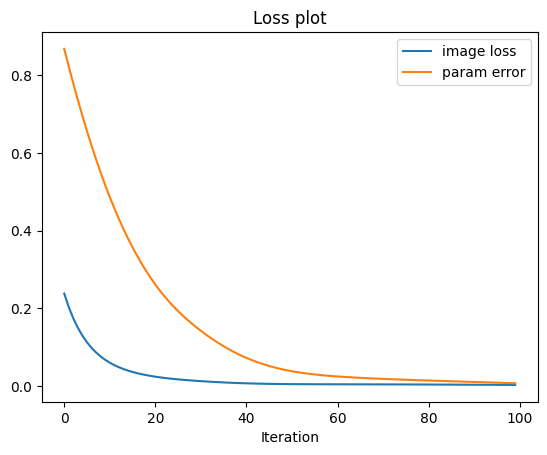

In [5]:
# Loss plots
plt.plot(record['image_loss'], label='image loss')
plt.plot(record['param_error'], label='param error')
plt.xlabel('Iteration') 
plt.title('Loss plot')
plt.legend()
plt.show()

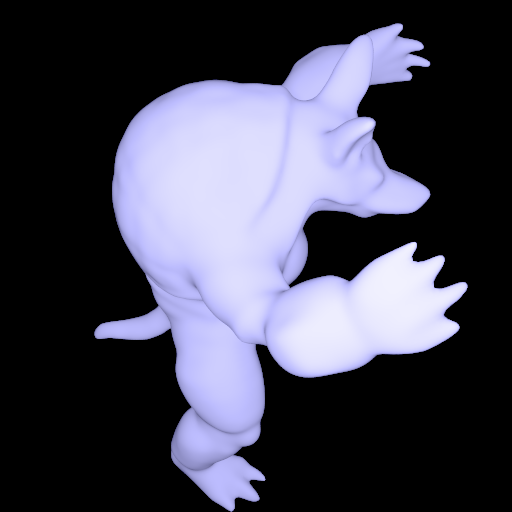

In [6]:
# Display the optimization process
write_video('image_opt.gif', record['training_view'], kwargs={'loop': True})
Image('image_opt.gif')

In [7]:
# Clean up
Path('image_opt.gif').unlink()